# Modeling spawning salmon

The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

In [1]:
import os

# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [3]:
Ts = [1.5, 4.5]
As = [0.4, 0.6]

n_samples = 128
edc = np.zeros(n_samples)
times = np.linspace(0, 3, n_samples)
for T_i, A_i in zip(Ts, As):
     edc += A_i*np.exp(-13.8/T_i*times)

edc = 10**((10*np.log10(edc) + np.random.normal(0, 0.25, n_samples))/10)

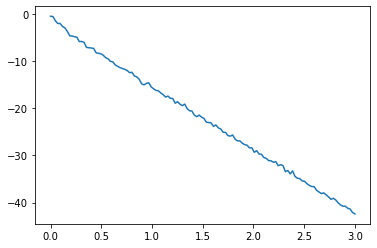

In [4]:
plt.plot(times, 10*np.log10(edc))

## Gaussian Process

In [10]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=1/Ts[0])
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.Normal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('edc', X=times.reshape(-1, 1),
                           y=10*np.log10(np.abs(edc)), noise=σ)
    

In [15]:
with gp_salmon_model:
    gp_trace = pm.sample(100, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 61 seconds.
The number of effective samples is smaller than 25% for some parameters.


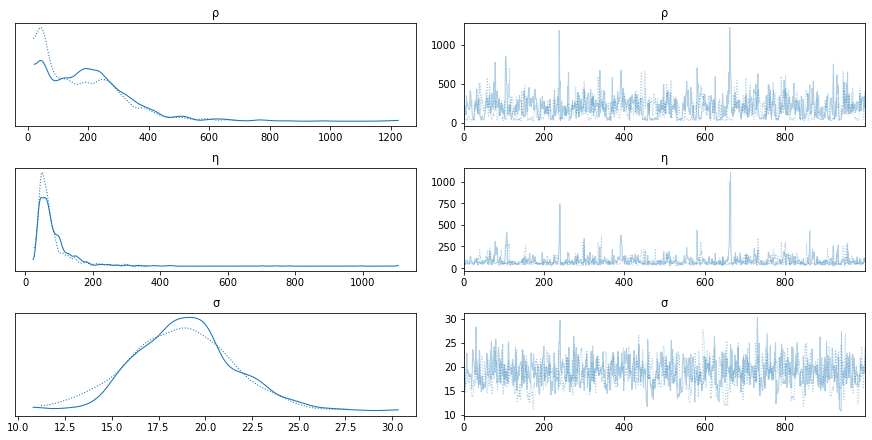

In [16]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [21]:
del salmon_pred

In [64]:
X_pred = salmon_data.spawners.values.reshape(-1,1)

In [69]:
with gp_salmon_model:
    salmon_pred_3 = recruit_gp.conditional("salmon_pred_3", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred_3'], samples=3, random_seed=42)

ValueError: Variable name salmon_pred_2 already exists.

In [68]:
gp_salmon_samples['salmon_pred_2'].shape

(3, 100)

In [66]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_salmon_samples['salmon_pred_2']:
    ax.plot(X_pred, x);

ValueError: x and y must have same first dimension, but have shapes (40, 1) and (100,)

In [58]:
with gp_salmon_model:
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred_2'], samples=500, random_seed=42)

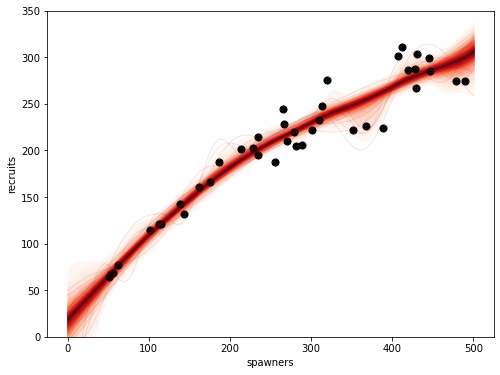

In [59]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred_2'], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

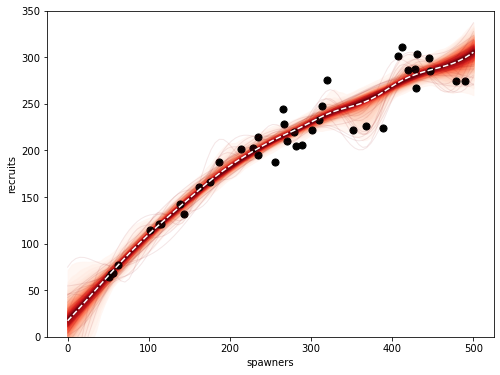

In [60]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred_2'], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.plot(X_pred, np.mean(gp_salmon_samples['salmon_pred_2'], axis=0), label='mean', color='w', linestyle='--')
ax.set_ylim(0, 350);


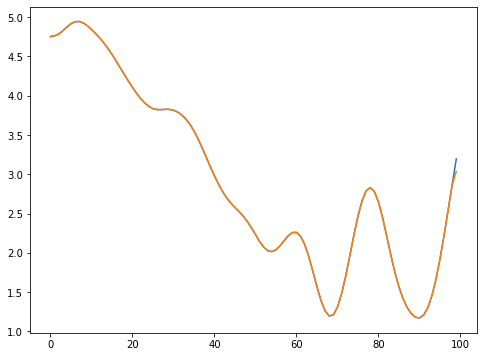

In [62]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(np.gradient(np.mean(gp_salmon_samples['salmon_pred_2'], axis=0), edge_order=2))
plt.plot(np.gradient(np.mean(gp_salmon_samples['salmon_pred_2'], axis=0)))

In [51]:
with gp_salmon_model:
    # salmon_pred_noise = recruit_gp.conditional("salmon_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred_noise'], samples=500, random_seed=42)

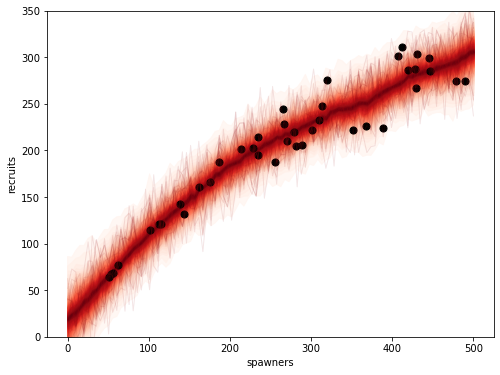

In [52]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples['salmon_pred_noise'], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution that covers this range of spawners.

*Hint: you need to add a new `conditional` variable.*

In [ ]:
# Write answer here